In [10]:
import os
import matplotlib.pyplot as plt
from torch import optim, utils, nn, Tensor
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
import lightning.pytorch as pl
import torch

In [2]:
encoder = nn.Sequential(nn.Linear(28*28, 128), nn.ReLU(), nn.Linear(128, 64))
decoder = nn.Sequential(nn.Linear(64, 128), nn.ReLU(), nn.Linear(128, 28*28))

In [17]:
class LitAutoEncoder(pl.LightningModule):

  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder

  def training_step(self, batch, batch_idx):
    x, y = batch
    x = x.view(x.size(0), -1)
    z = self.encoder(x)
    x_hat = self.decoder(z)
    loss = nn.functional.mse_loss(x_hat, x)
    self.log('train_loss', loss)
    return loss

  def configure_optimizers(self):
    optimizer = optim.Adam(self.parameters(), lr = 1e-3)
    return optimizer

autoencoder = LitAutoEncoder(encoder, decoder)

In [18]:
dataset = MNIST(os.getcwd(), download = True, transform = ToTensor())
train_loader = utils.data.DataLoader(dataset)

In [19]:
trainer = pl.Trainer(limit_train_batches = 100, max_epochs = 1)
trainer.fit(model = autoencoder, train_dataloaders = train_loader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 108 K 
1 | decoder | Sequential | 109 K 
---------------------------------------
218 K     Trainable params
0         Non-trainable params
218 K     Total params
0.873     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 108 K 
1 | decoder | Sequential | 109 K 
-

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [14]:
checkpoint = "./lightning_logs/version_1/checkpoints/epoch=0-step=100.ckpt"
autoencoder = LitAutoEncoder.load_from_checkpoint(checkpoint, encoder = encoder, decoder = decoder)

encoder = autoencoder.encoder
encoder.eval()

fake_image_batch = torch.rand(1, 28*28, device = autoencoder.device)
embeddings = encoder(fake_image_batch)
print("\nPredictions (Embedding for an image): \n", embeddings, "\n")


Predictions (Embedding for an image): 
 tensor([[-0.4270,  0.1075, -0.0797,  0.0459, -0.6321, -0.0861,  0.0393,  0.0888,
         -0.7959,  0.1648, -0.0509,  0.3752, -0.1239,  0.6815,  0.1394, -0.5876,
          0.0902,  0.4283, -0.3486, -0.0307,  0.0211, -0.0811,  0.4356, -0.1576,
         -0.0930,  0.2553, -0.2296, -0.2324, -0.2152, -0.7752,  1.3222,  0.0782,
          0.1303,  0.8078, -0.2281, -0.2016, -0.5233,  0.2960, -0.4285,  0.8623,
          0.2907,  0.9810,  0.6583,  0.2396, -0.0214,  0.0931, -0.1395, -0.6779,
          0.3916,  0.6915,  0.3075,  0.1020, -0.6499, -0.2279,  0.0146, -0.7818,
         -0.0513,  0.2880, -0.3145,  0.5439,  0.0527, -0.4709,  0.0728,  0.2945]],
       grad_fn=<AddmmBackward0>) 



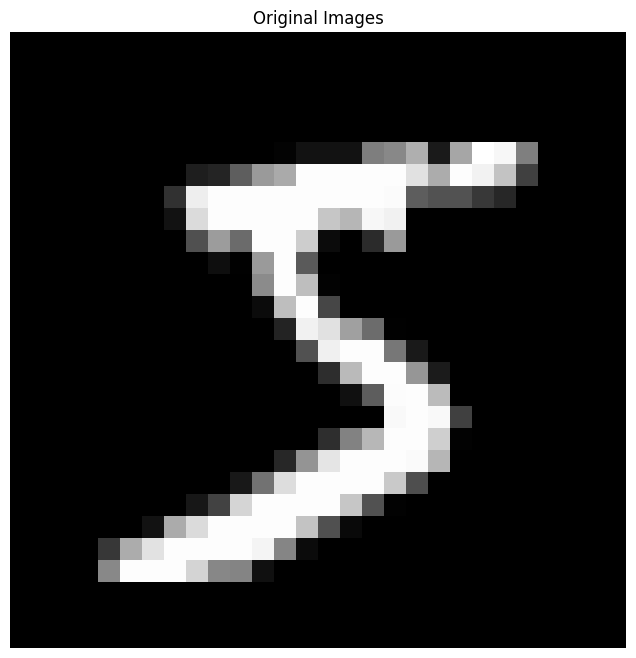

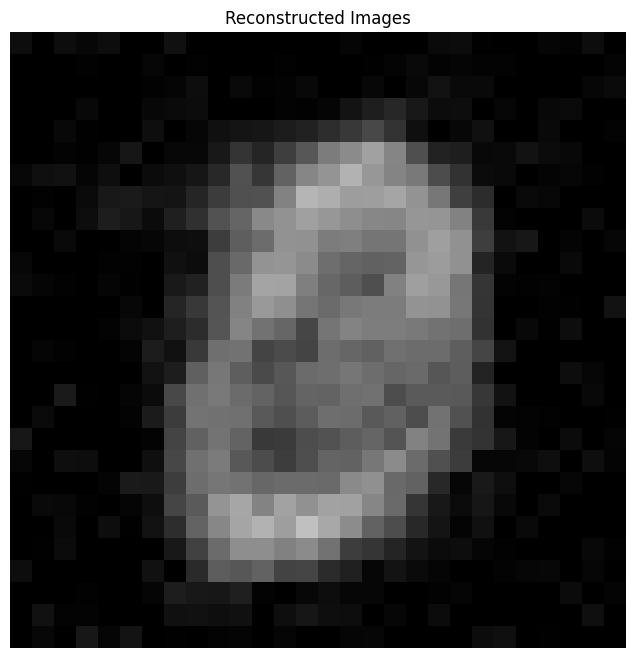

In [16]:
def show_images(images, title = "Images"):
  grid_img = make_grid(images, nrow = 4)
  plt.figure(figsize = (8, 8))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.title(title)
  plt.axis('off')
  plt.show()

images, _ = next(iter(train_loader))
show_images(images, title = "Original Images")

images = images.view(images.size(0), -1)

embeddings = autoencoder.encoder(images)
recontructed_images = autoencoder.decoder(embeddings).view(-1, 1, 28, 28)
show_images(recontructed_images, title = "Reconstructed Images")